## LAB06

In [1]:
library(ggplot2)
library(coda)
library(rstan)
library(tibble)

Loading required package: StanHeaders

rstan (Version 2.21.8, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Do not specify '-march=native' in 'LOCAL_CPPFLAGS' or a Makevars file


Attaching package: 'rstan'


The following object is masked from 'package:coda':

    traceplot




In [2]:
Sys.setenv(JAGS_HOME="C:/Program Files/JAGS/JAGS-4.3.1")
library(rjags)

Linked to JAGS 4.3.1

Loaded modules: basemod,bugs



In [3]:
library(dplyr)
library(lubridate)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union




### Exercise 1

Given the following un-normalized posterior distribution

\begin{equation*}
g(θ|x) \propto \frac{1}{2}*exp \frac{-(\theta+3)^2}{2} + \frac{1}{2}*exp \frac{-(\theta-3)^2}{2}
\end{equation*}

- draw a Markov Chain from the posterior distribution using a Metropolis-Hastings algorithm

- use a Norm (0, 1) as random-walk candidate density

In [4]:
testfunc <- function(theta) {
                a = 0.5*exp((-(theta+3)^2)/2) + 0.5*exp((-(theta-3)^2)/2)
                return( a )
}

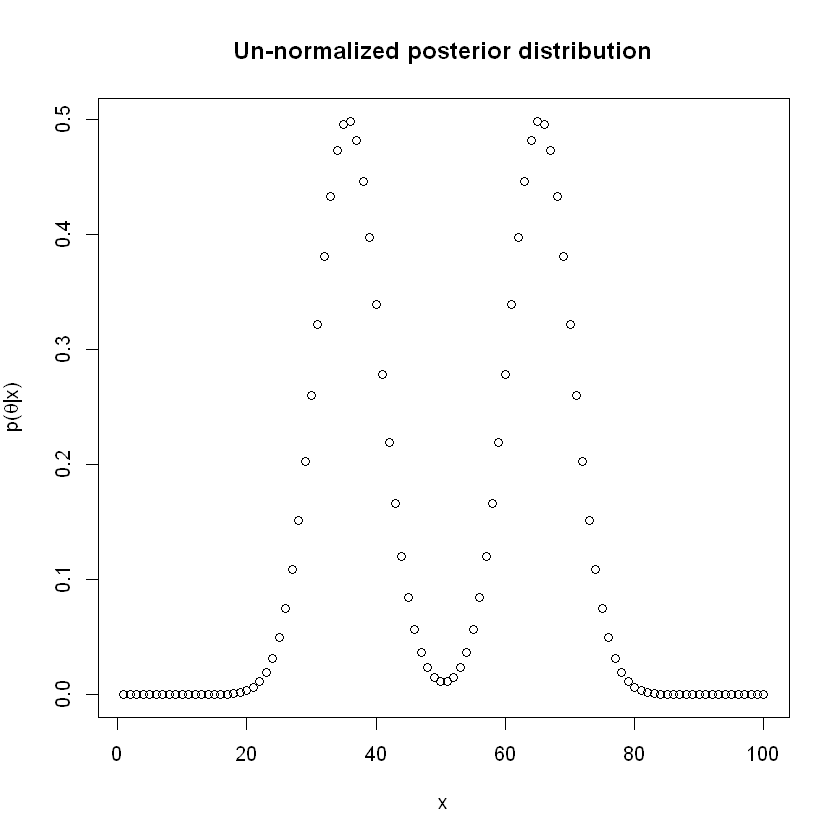

In [5]:
x <- seq(-10,10,length.out = 100)
plot(testfunc(x), xlab='x', ylab=expression(paste("p(", theta, "|x)")), main="Un-normalized posterior distribution")

In [6]:
# Markov Chain using a Metropolis-Hasting algorithm

MCMC.func <- function(func, theta.init, n_samples, sigma) { 
        # empty vector for accepted samples
        values <- c() 
        # initialize the chain at some value
        theta_init <- func(theta.init)
    
        for (i in 1:n_samples){
            
            # draw a random sample from a distribution
            sample <- rnorm(1, mean=0, sd = sigma)
            # new candidate sample
            theta_new <- func(sample)
            
            # dedice whether to accept or not the new candidate sample
            if (theta_new > theta_init){
                theta_init <- theta_new
                x <- sample
            }
            else {
                p <- theta_new/theta_init
                
                t <- runif(1, min = 0, max = 1) #rnorm(1, mean=0,sd=1) #
                
                if (t <= p){
                    theta_init <- theta_new
                    x <- sample
                }
                else {
                    theta_init <- theta_init
                    x <- theta.init
                }
            }
        
        values <- c(values,x)
        theta.init <- x
        }
    
        return(values)
    }

In [7]:
# set parameters

theta.init <- -3
sigma <- 1
n.samples <- 10^5

set.seed(1234)

mcmc_result <- MCMC.func(testfunc, theta.init, n.samples, sigma )


- plot the sampled distribution

Warning message:
"`stat(density)` was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead."


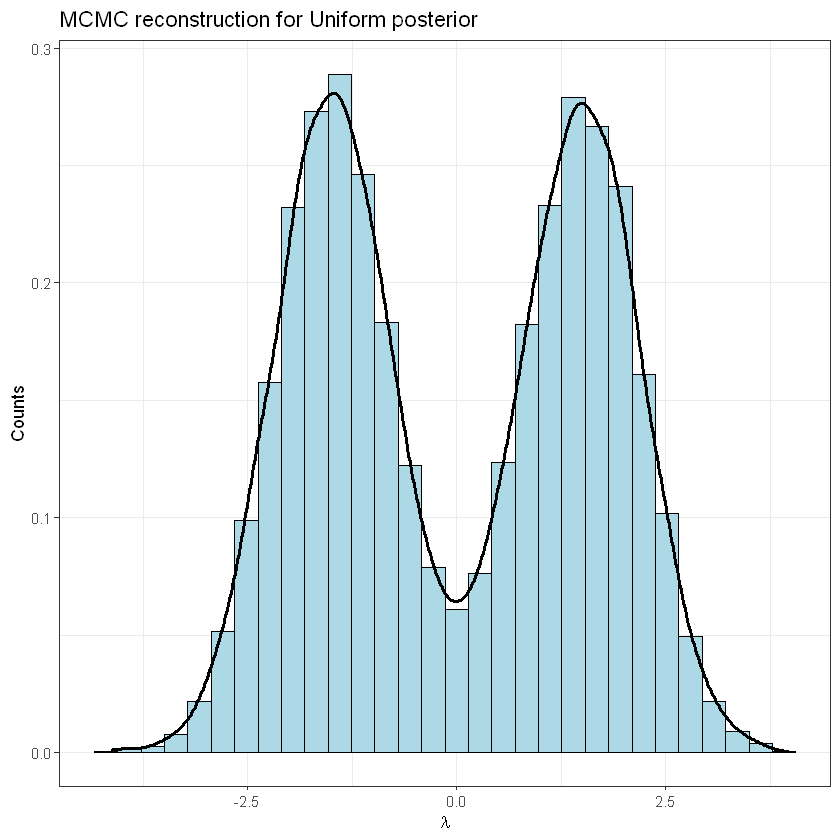

In [8]:
#mcmc_uniform <- mcmc_uniform/sum(mcmc_uniform)
df_mcmc <- data.frame(mcmc_result)

# plot histogram
ggplot(df_mcmc, aes(x = mcmc_result)) +
    geom_histogram(aes(y = stat(density)), color="black",fill="light blue", bins=30) +
    geom_density(lwd = 1, linetype = 1) +

    labs(x =expression(lambda), y = "Counts", color = "") +
    ggtitle("MCMC reconstruction for Uniform posterior") +
    theme_bw() 

- analyze the chain with the CODA package and plot the chain autocorrelation


Iterations = 1:1e+05
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 1e+05 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     -0.005234       1.650993       0.005221       0.014192 

2. Quantiles for each variable:

   2.5%     25%     50%     75%   97.5% 
-2.6414 -1.4936 -0.0413  1.4981  2.6362 


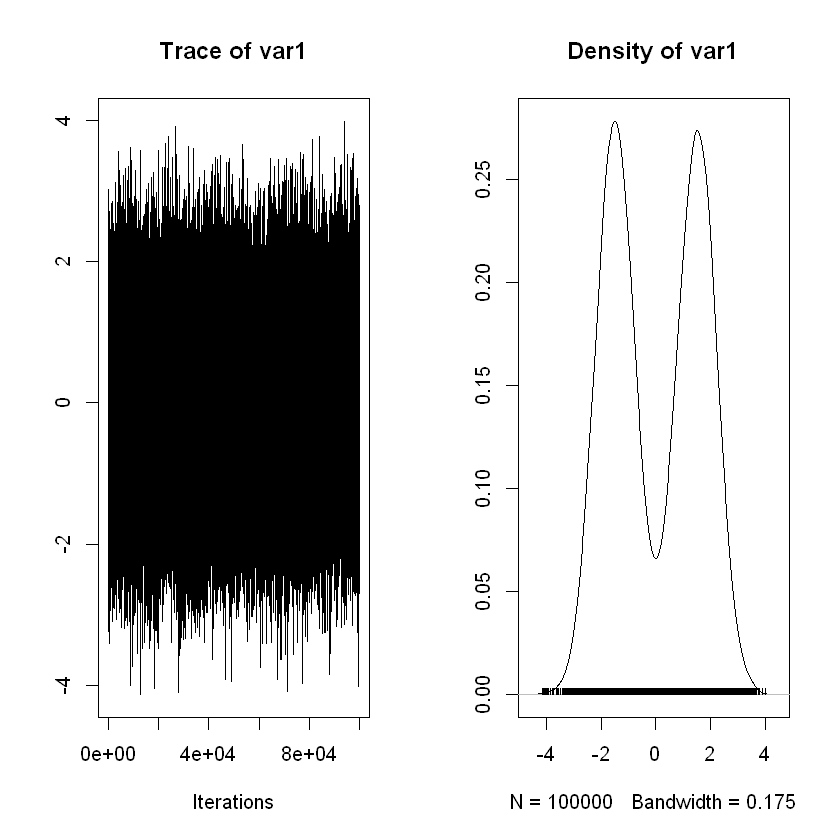

In [10]:
# display summary
summary(mcmc(mcmc_result))

# plot result
plot(mcmc(mcmc_result))

- try to use different burn-in cycles and thinning and plot the corresponding posterior distribution and the chain autocorrelation function. What are the best parameters ?

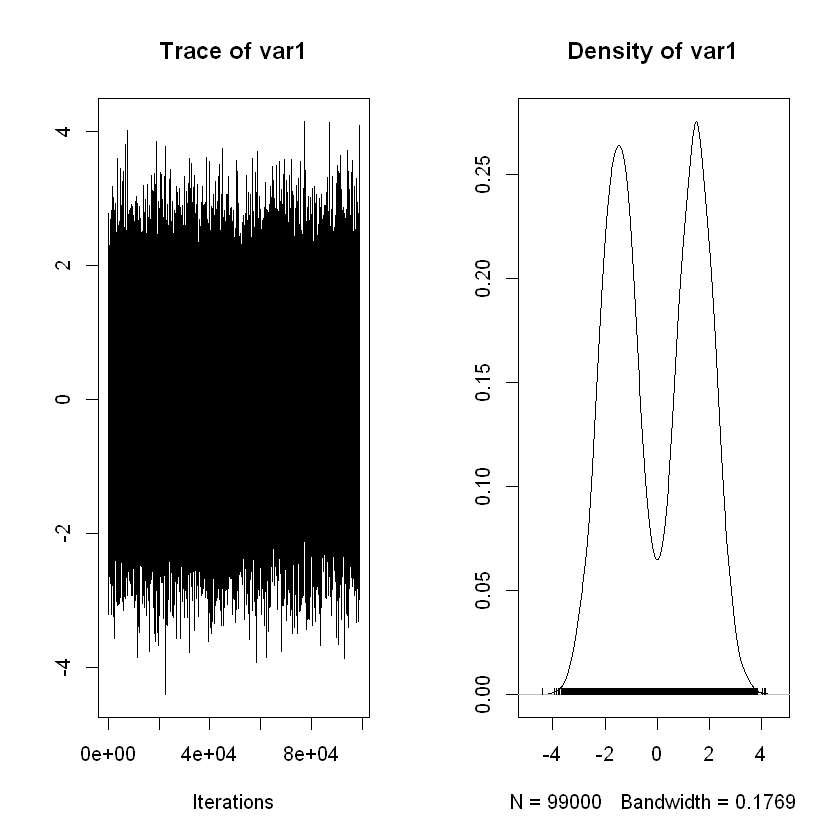

Burn-in value: 1000  Thinning value: 1 


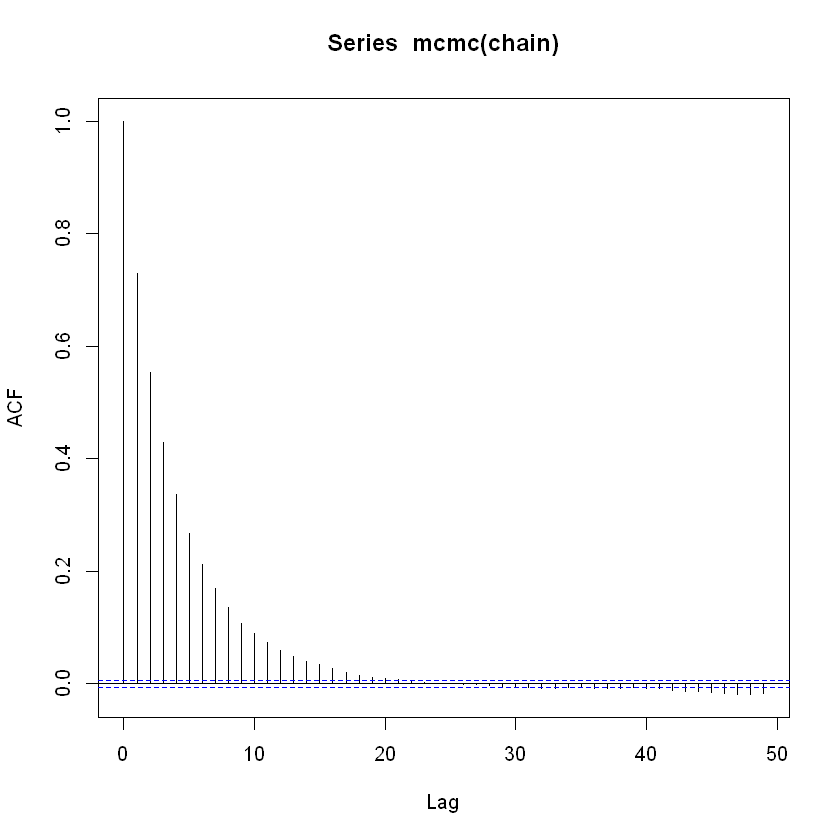

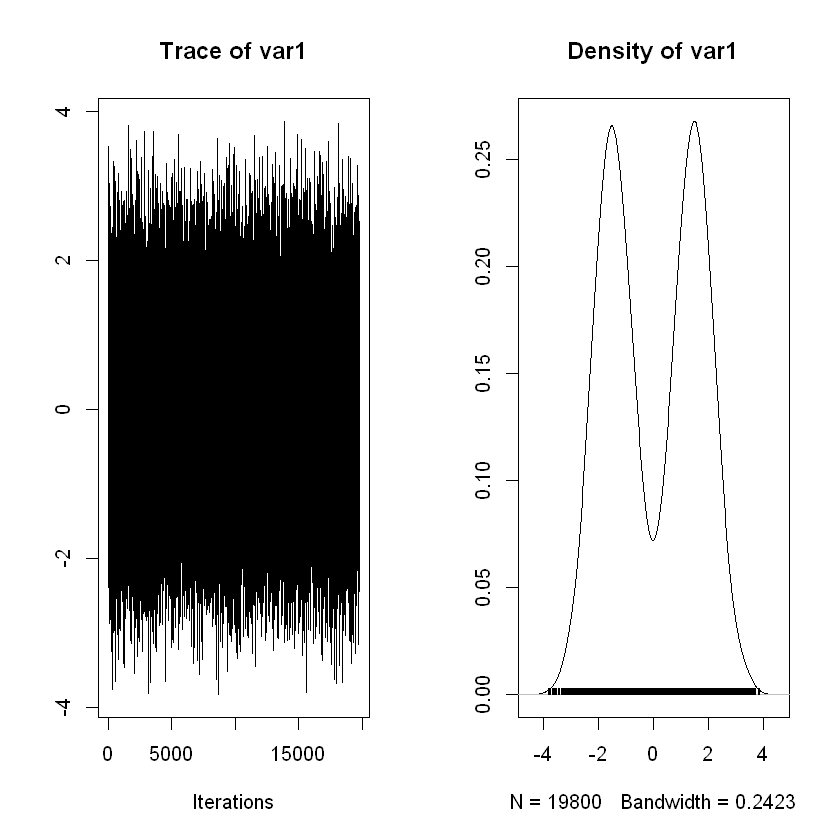

Burn-in value: 1000  Thinning value: 5 


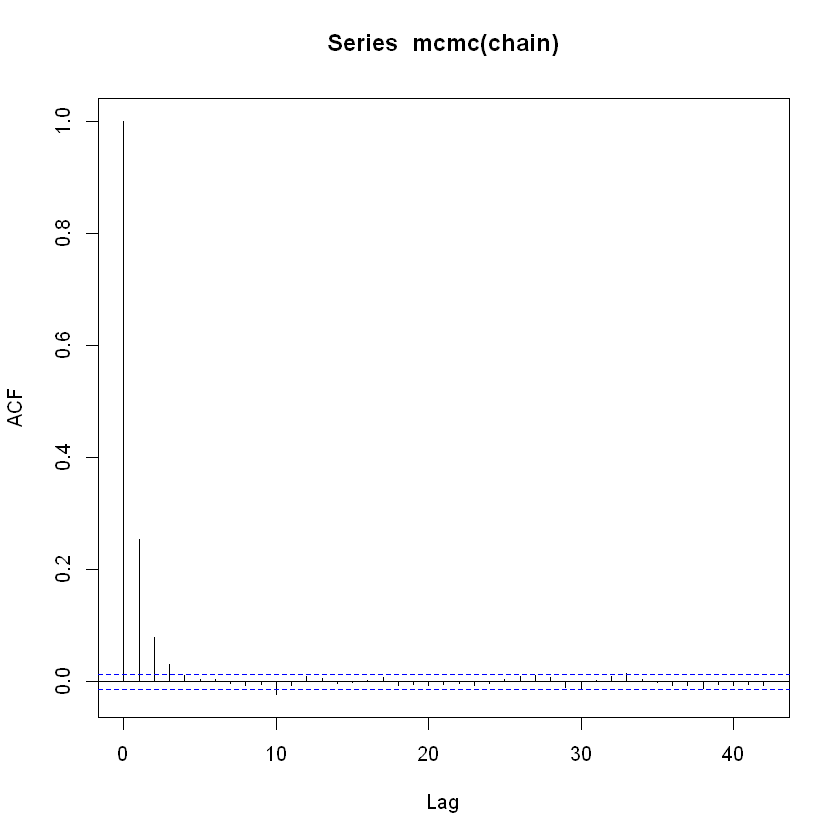

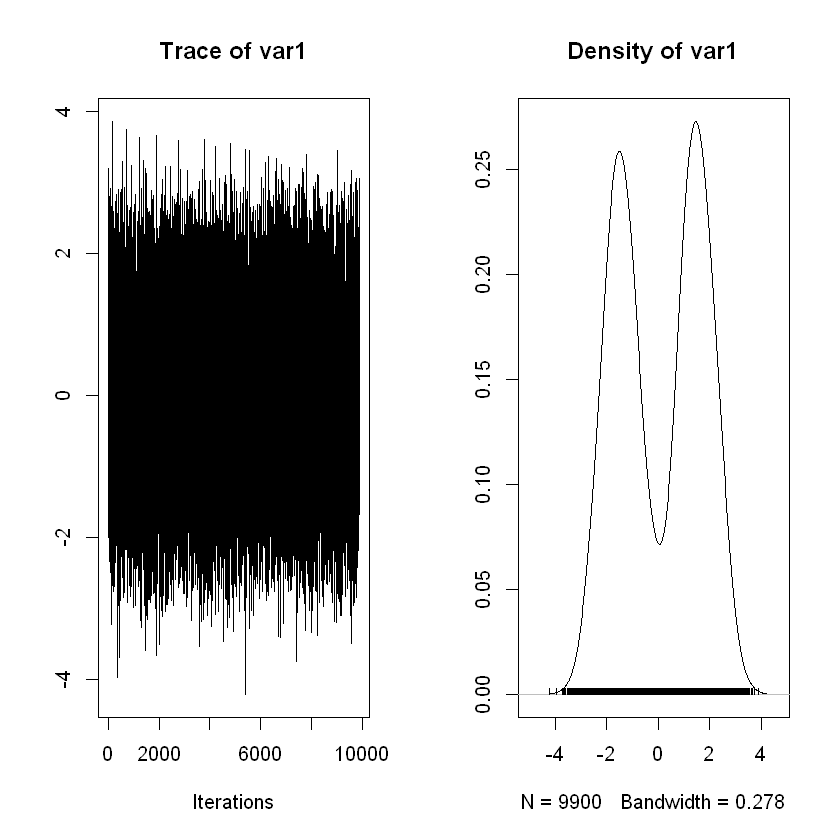

Burn-in value: 1000  Thinning value: 10 


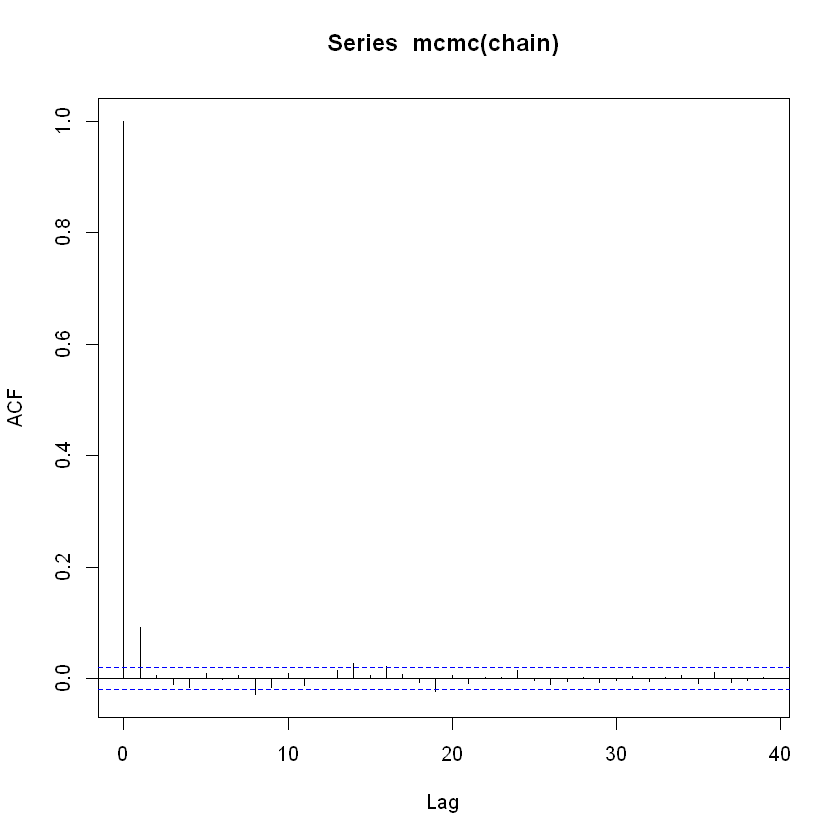

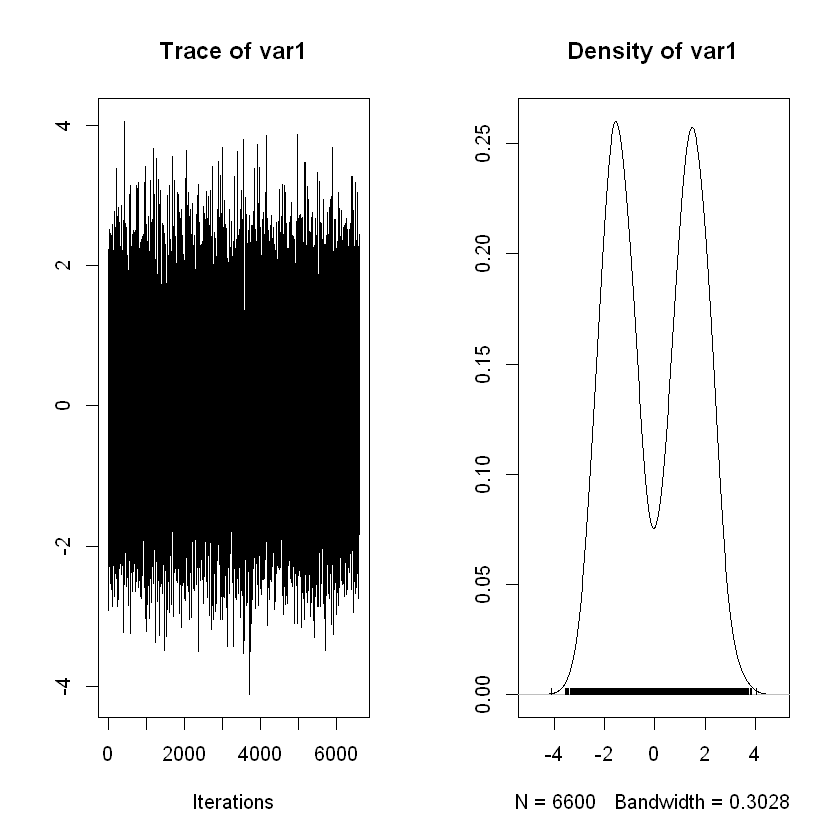

Burn-in value: 1000  Thinning value: 15 


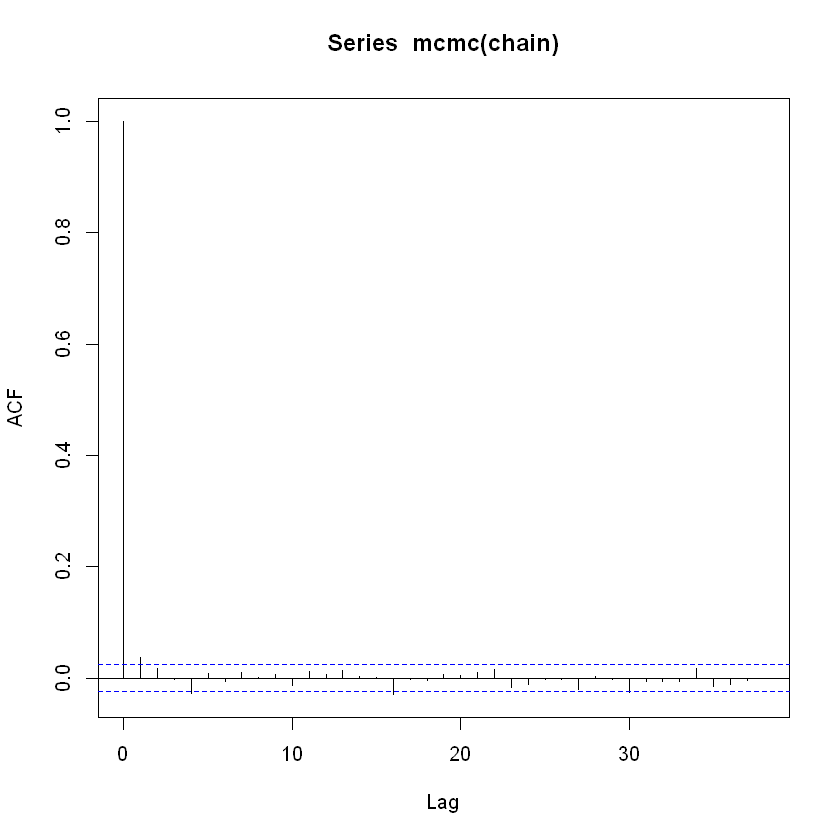

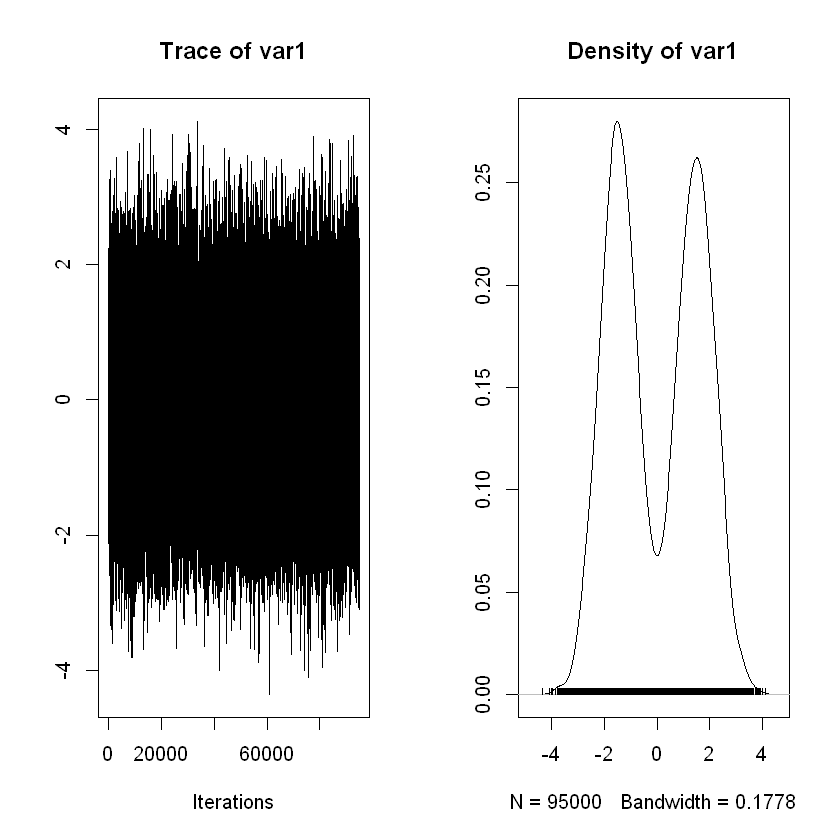

Burn-in value: 5000  Thinning value: 1 


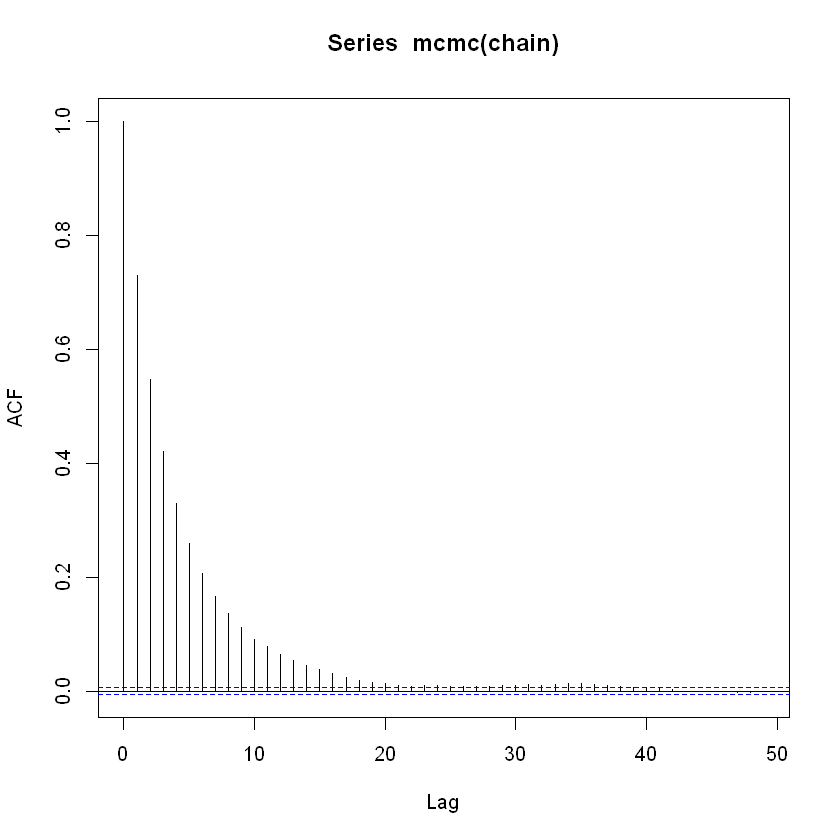

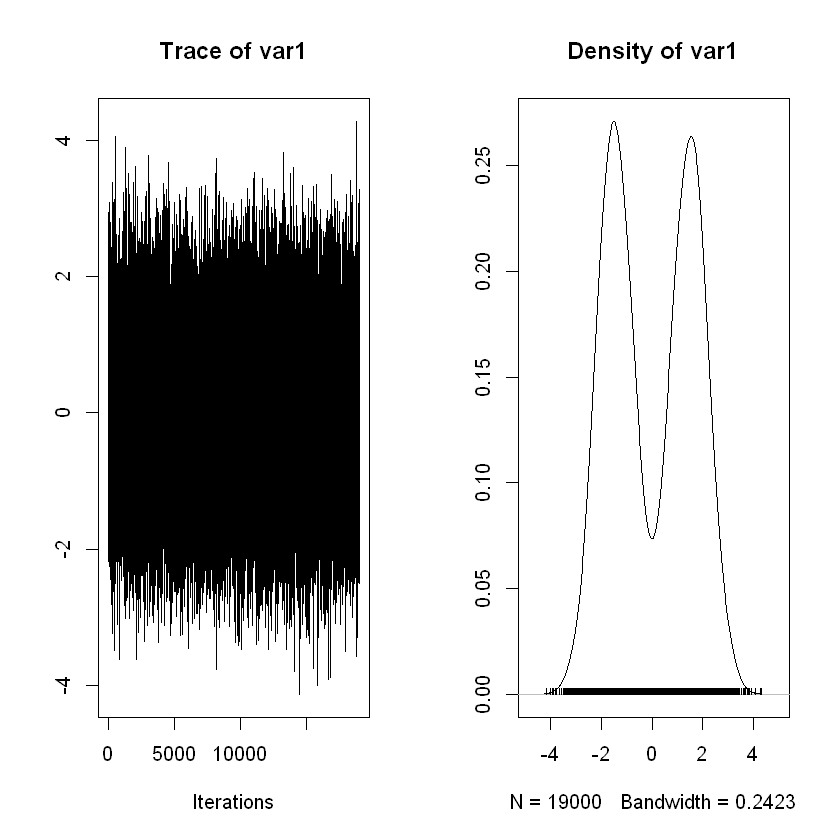

Burn-in value: 5000  Thinning value: 5 


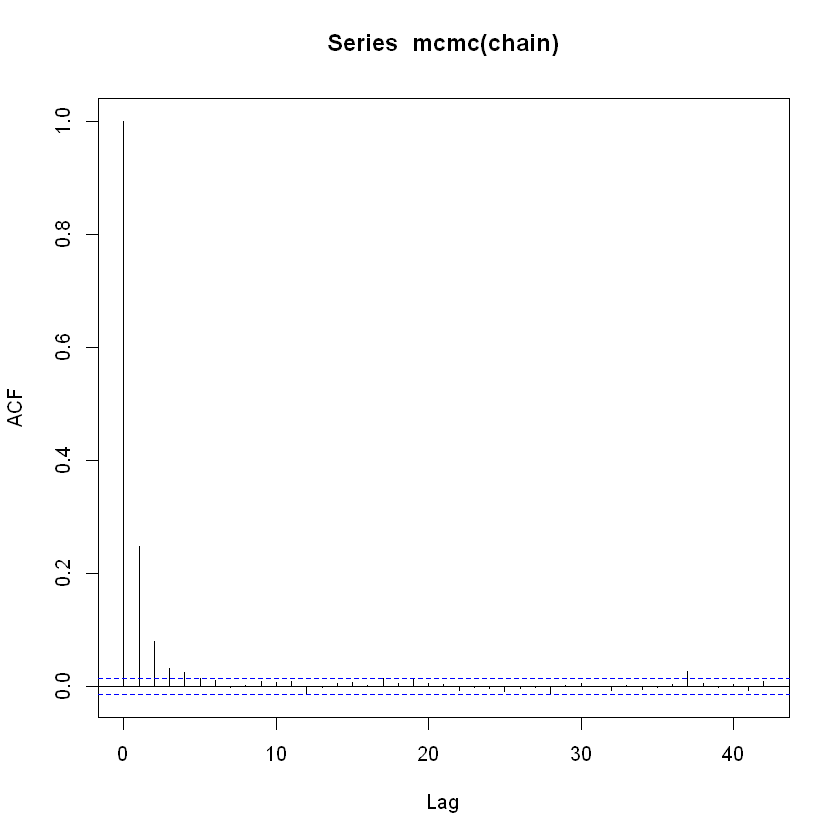

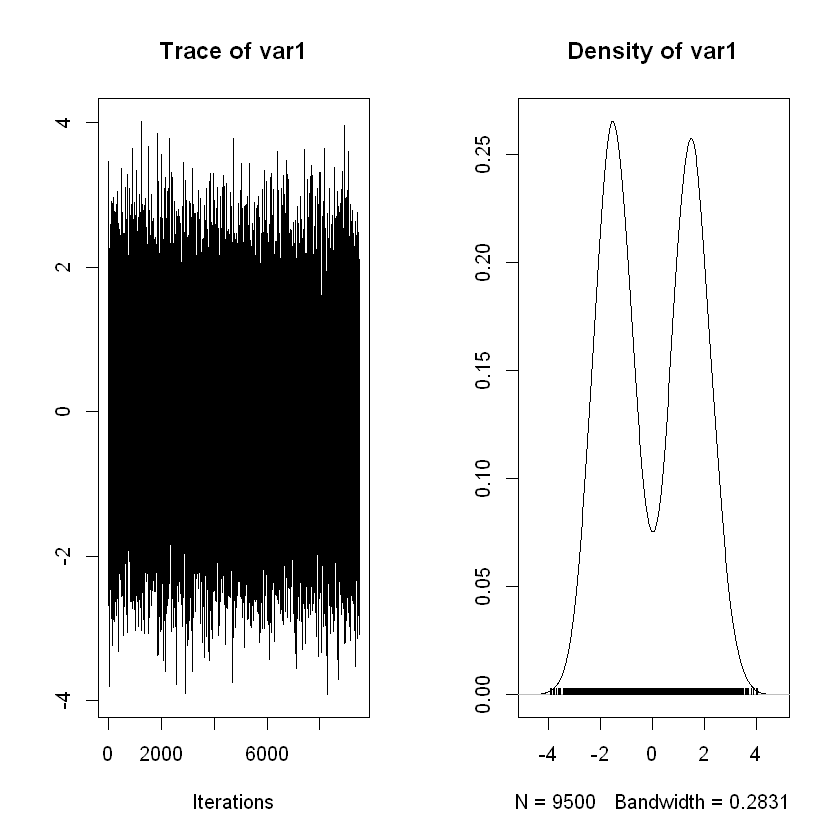

Burn-in value: 5000  Thinning value: 10 


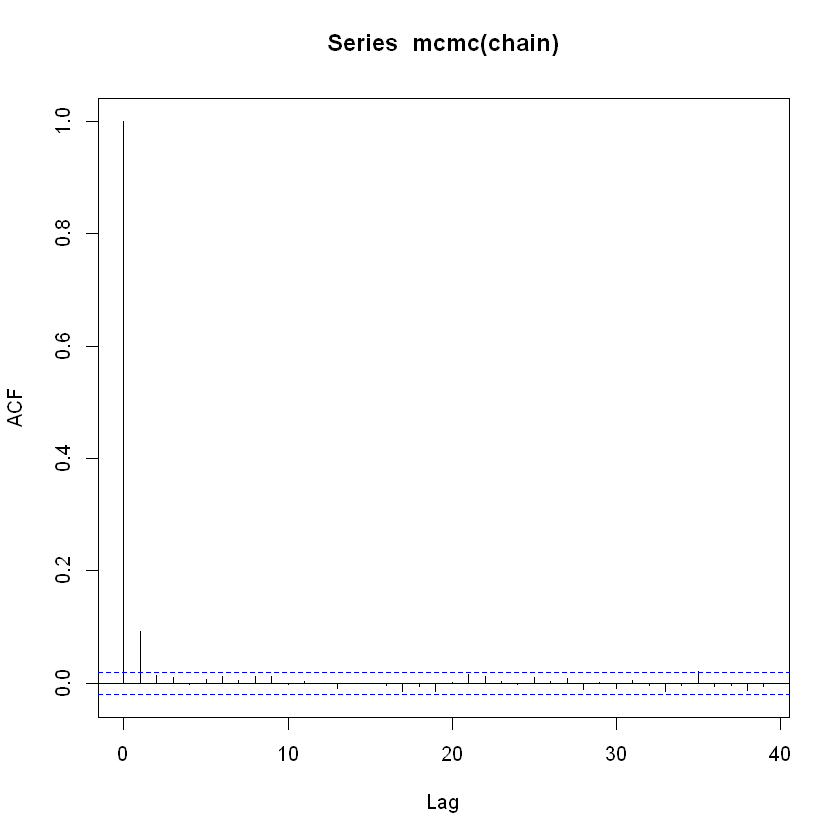

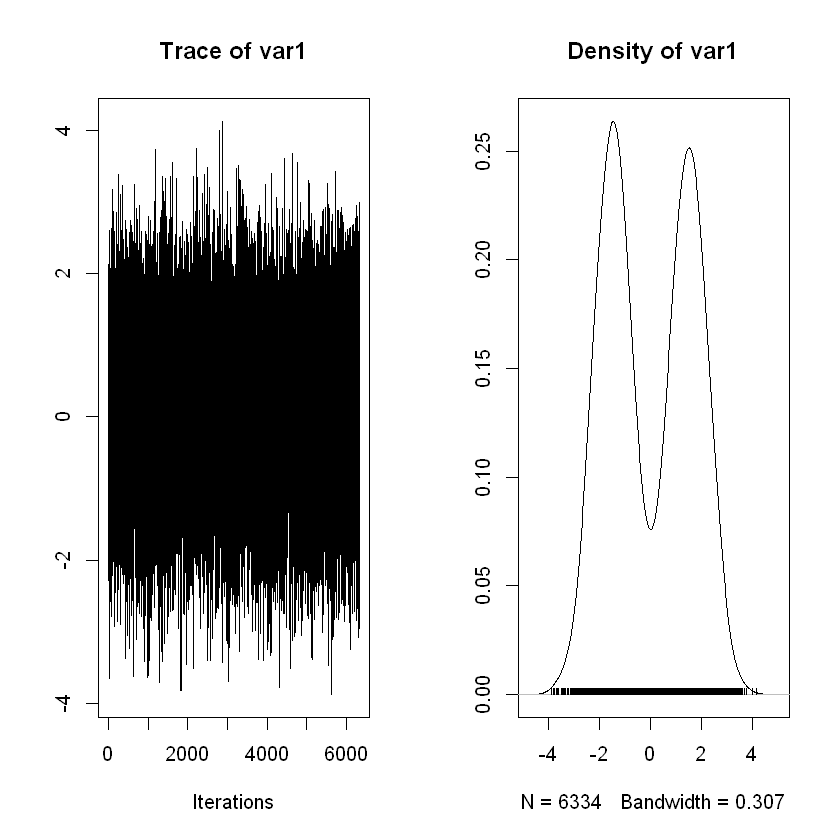

Burn-in value: 5000  Thinning value: 15 


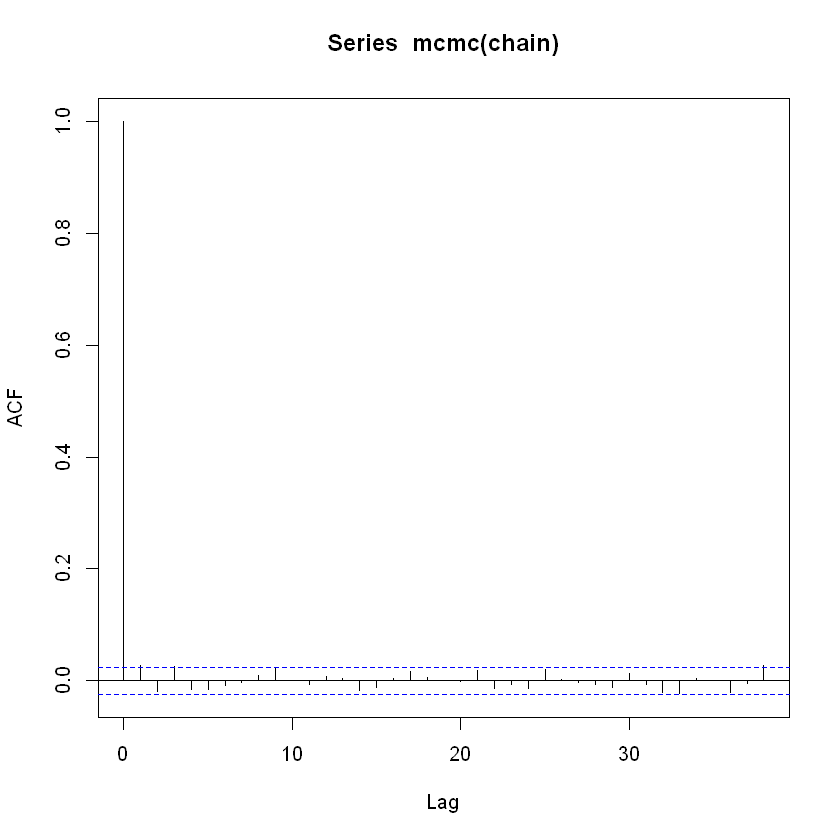

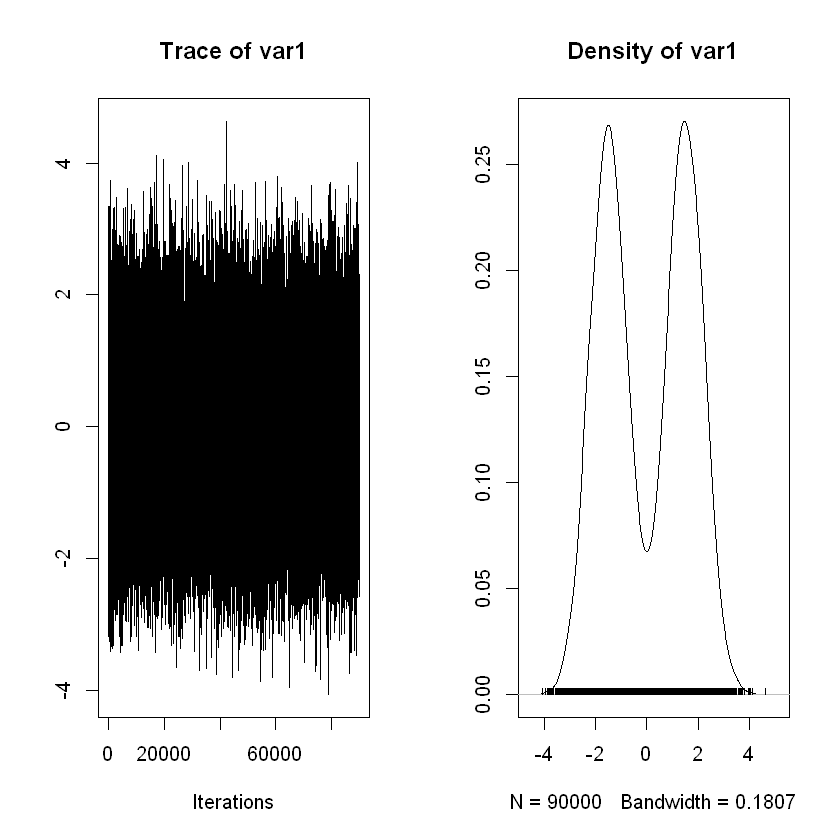

Burn-in value: 10000  Thinning value: 1 


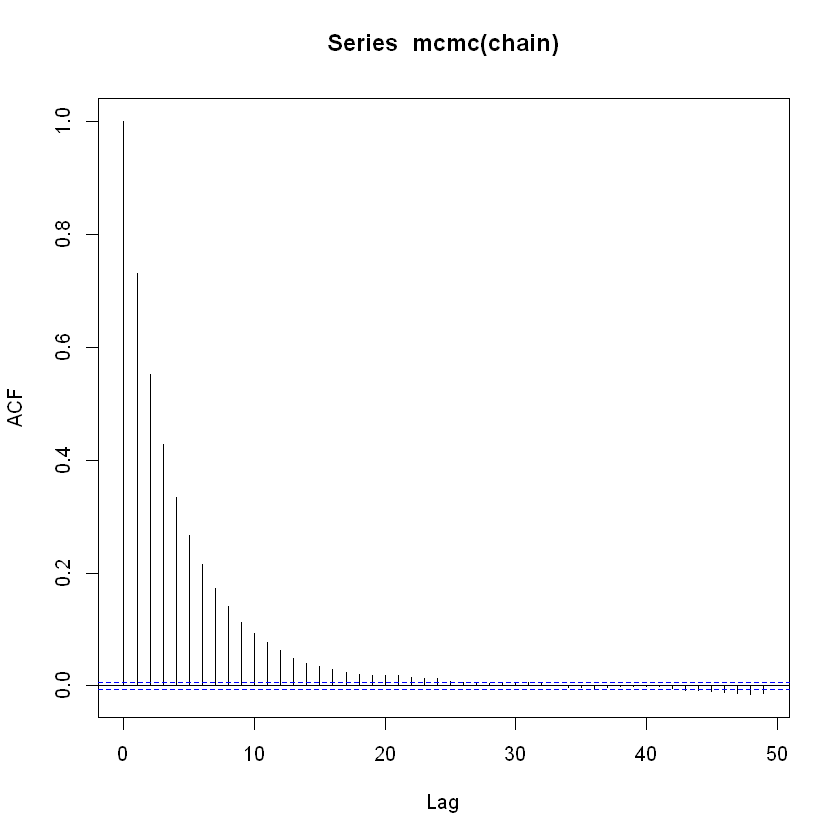

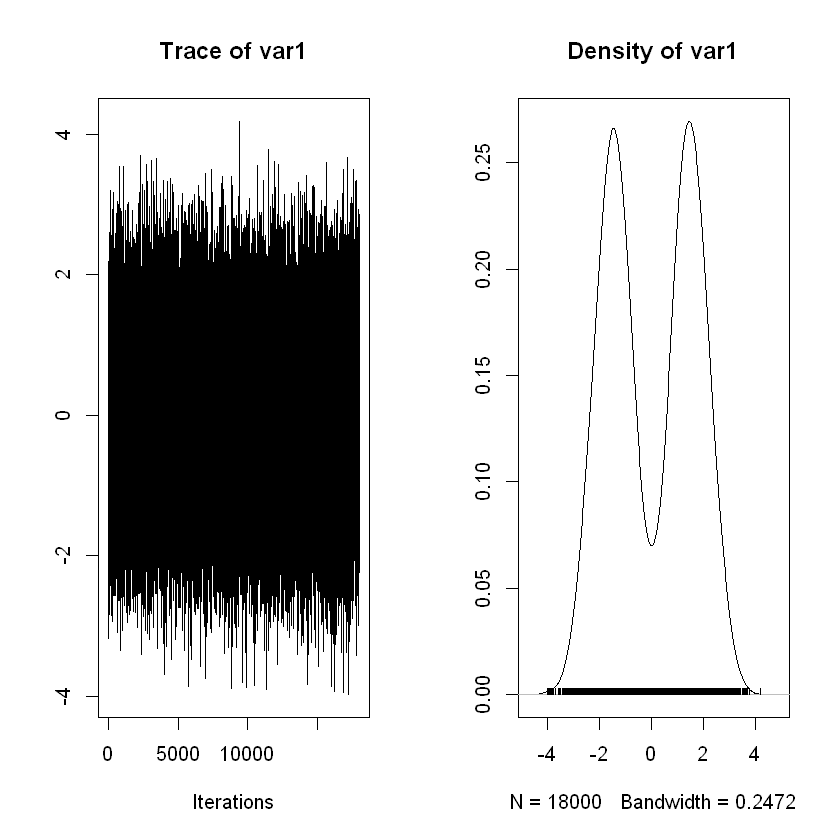

Burn-in value: 10000  Thinning value: 5 


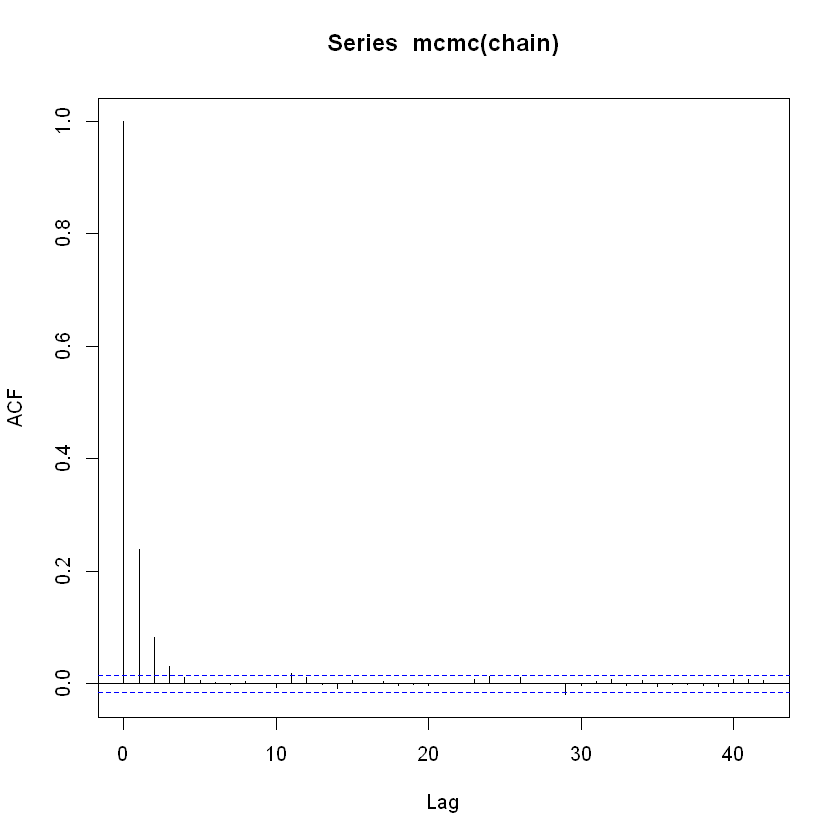

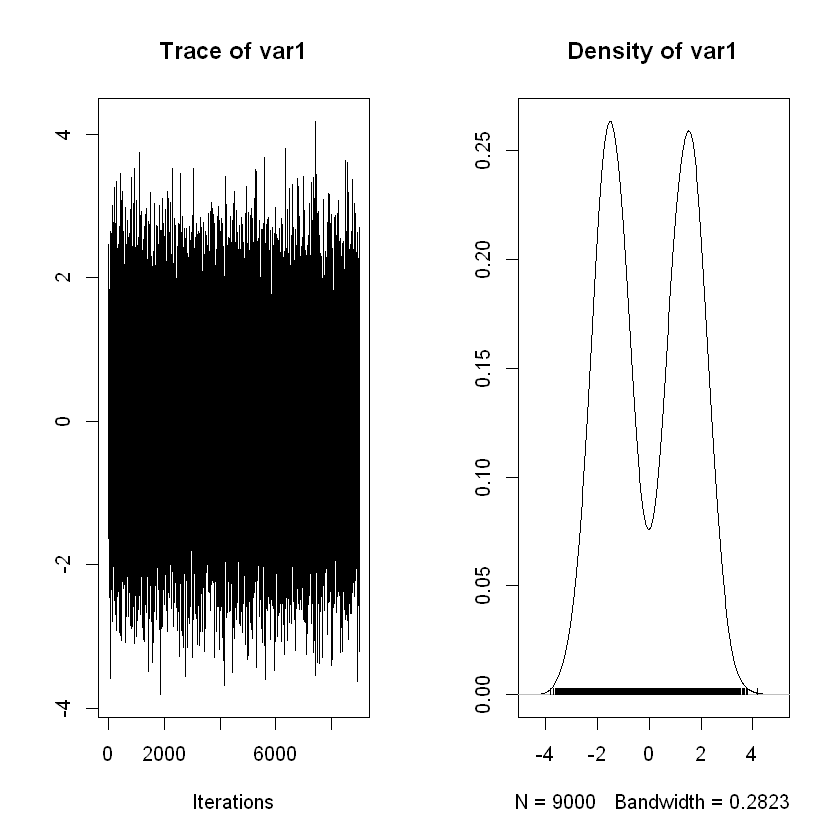

Burn-in value: 10000  Thinning value: 10 


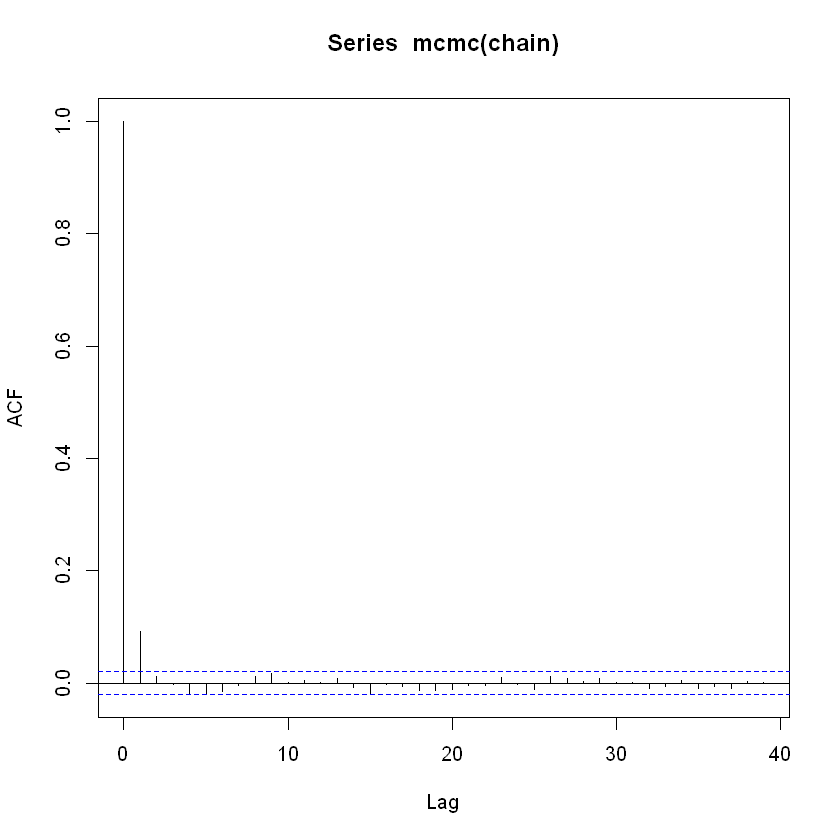

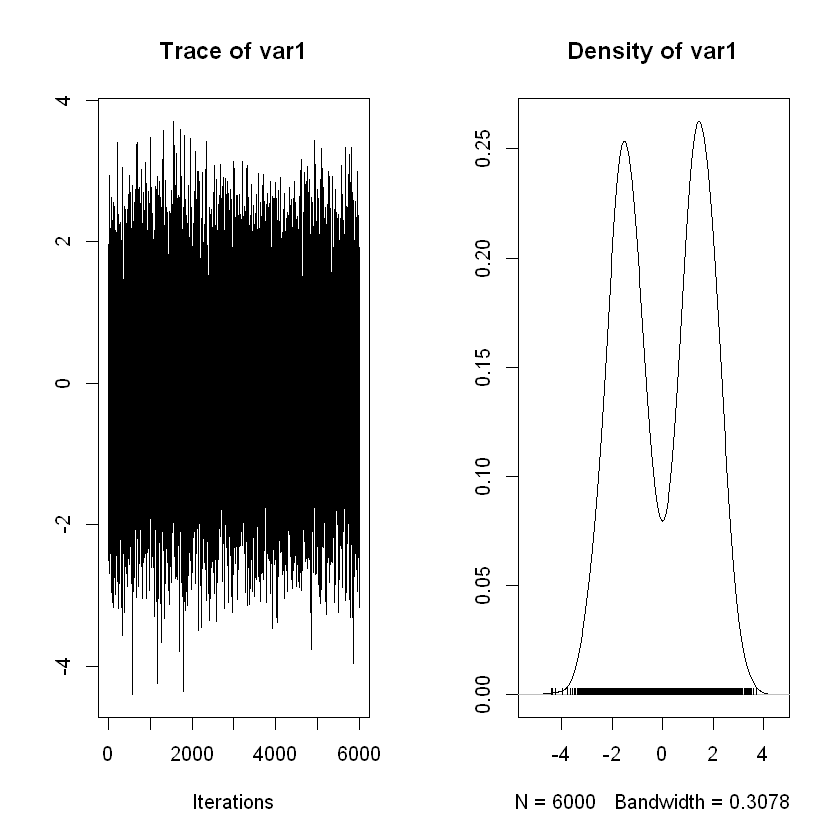

Burn-in value: 10000  Thinning value: 15 


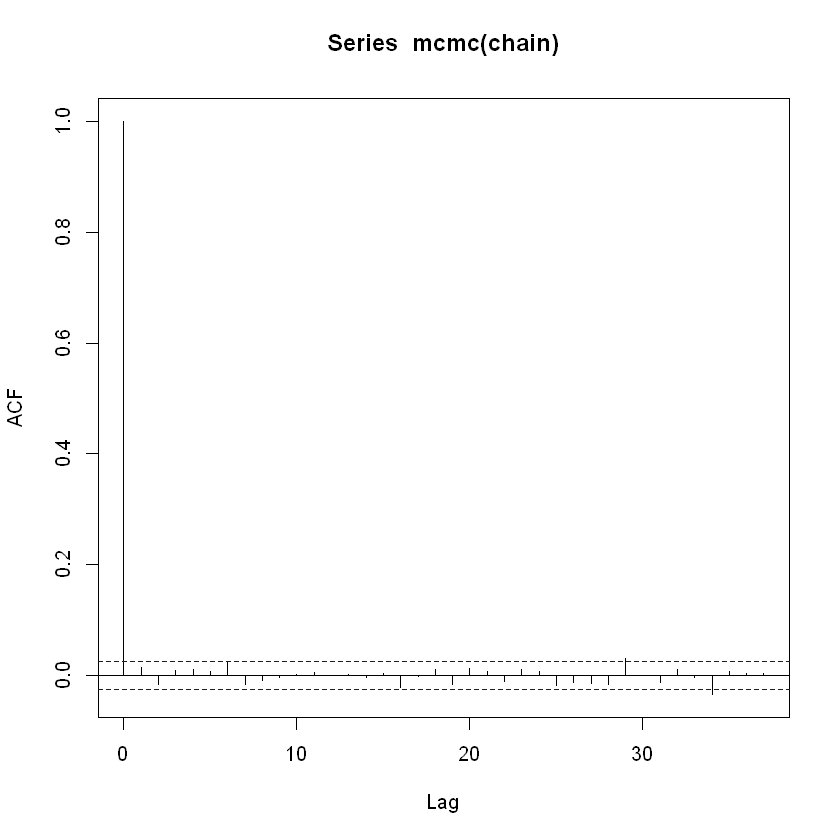

In [11]:
# setting the burn-in cycles and thinning parameters
burn_in_cycles <- c(1000, 5000, 10000)
thinning_params <- c(1, 5, 10, 15)

# iteration
for (burn_in in burn_in_cycles){
    for (thinning in thinning_params){
        # run MCMC
        chain <- MCMC.func(testfunc, theta.init, n.samples, sigma)
        
        # apply burn-in and thinning
        chain <- chain[(burn_in +1):n.samples]
        k <- seq(1, length(chain),thinning)
        chain <- chain[k]
        
        # plot posterior distribution
        plot(mcmc(chain))
        
        # plot chain autocorrelation function
        plot(acf(mcmc(chain)))
        
        # print params
        cat("Burn-in value:", burn_in, " Thinning value:", thinning, "\n")
    }
    
}

Notes: Here we notice that there is a significant spike at a lag of 1 and much lower spikes for the subsequent lags. It's clear that the higher the thinning, the spikes get lower. We can also see, that the convergence is achived for all the burn-in cycles proposed

### Exercise 2

- the European Medicines Agency (EMA) has authorized a list of COVID-19 vaccines, after having performed a scientific evaluation of the veccines efficacy. The following vaccines are currently authorized for use in the European Union:
    - Comirnaty (BioNTech and Pfizer)
    - VCOVID-19 Vaccine Valneva
    - Nuvaxovid (Novavax)
    - Pikevax (Moderna)
    - Vaxzeviria (AstraZeneca)
    - Jcovden (Janssen)
    - VidPrevtyn Beta (Sanofi Pasteur)
    - Bimervax, previously COVID-19 Vacxcine HIPRA (HIPRA Human Health S.L.U.)

- analyze the initial test data reported on the EMA Web site for the following early Vaccines
    - Janssen [1]
    - Moderna [2]
    - AstraZeneca [3]
    - Jcovden [4]
    
    and create a Markow Chain Monte Carlo JAGS or stan the efficacy of each Vaccine. Infere the 95% credibility interval.

##### Moderna 
(page 2-3)

[...] *Efficacy was calculated in around 28,000 people from 18 to 94 years of age who had no sign of previous infection.*

*The trial showed a 94.1% reduction in the number of symptomatic COVID-19 cases in the people who received the vaccine (11 out of 14,134 vaccinated people got COVID-19 with symptoms) compared with people who received dummy injections (185 out of 14,073 people who received dummy injections got COVID-19 with symptoms). This means that the vaccine demonstrated a 94.1% efficacy in the trial. The trial also showed 90.9% efficacy in participants at risk of severe COVID-19* [...]

In [12]:
# moderna

tot_vaccine <- 14134
tot_placebo <- 14073
n_patients = c(rep('vaccine',tot_vaccine), 
               rep('placebo', tot_placebo)) # people in total

# number of patient with symptoms
pos_vaccine <- 11
pos_placebo <- 185

tested <- c(rep("Pos", pos_vaccine),
            rep("Neg", tot_vaccine - pos_vaccine),
            rep("Pos", pos_placebo),
            rep("Neg", tot_placebo - pos_placebo ))

moderna.tb <- tibble(tested = tested , patient=n_patients)
table(moderna.tb[[2]], moderna.tb[[1]])

         
            Neg   Pos
  placebo 13888   185
  vaccine 14123    11

In [13]:
# organize data in a list for usage in JAGS
dataList_moderna = list(
                        tested = ifelse(moderna.tb$tested == "Neg", 0, 1),
                        patient = as.integer(factor(moderna.tb$patient )),
                        Ntot = nrow(moderna.tb),
                        Nclass = nlevels(factor(moderna.tb$patient ))
                    )

##### Astrazeneca
(page 2)

[...] *These showed a 59.5% reduction in the number of symptomatic COVID-19 cases in people given the vaccine (64 of 5,258 got COVID-19 with symptoms) compared with people given control injections (154 of 5,210 got COVID-19 with symptoms). This means that the vaccine demonstrated around a 60% efficacy in these clinical trials.* [...]

In [14]:
# astrazeneca

tot_vaccine <- 5258
tot_placebo <- 5210
n_patients = c(rep('vaccine',tot_vaccine), 
               rep('placebo', tot_placebo)) # people in total

# number of patient with symptoms
pos_vaccine <- 64
pos_placebo <- 154

tested <- c(rep("Pos", pos_vaccine),
            rep("Neg", tot_vaccine - pos_vaccine),
            rep("Pos", pos_placebo),
            rep("Neg", tot_placebo - pos_placebo ))

astrazeneca.tb <- tibble(tested = tested , patient=n_patients)
table(astrazeneca.tb[[2]], astrazeneca.tb[[1]])

         
           Neg  Pos
  placebo 5056  154
  vaccine 5194   64

In [15]:
# organize data in a list for usage in JAGS
dataList_astrazeneca = list(
                            tested = ifelse(astrazeneca.tb$tested == "Neg", 0, 1),
                            patient = as.integer(factor(astrazeneca.tb$patient )),
                            Ntot = nrow(astrazeneca.tb) ,
                            Nclass = nlevels(factor(astrazeneca.tb$patient ))
                        )

##### Jcovden - Janssen
(page 2)

[...] *The trial found a 67% reduction in the number of symptomatic COVID-19 cases after 2 weeks in people who received Jcovden (116 cases out of 19,630 people) compared with people given placebo (348 of 19,691 people). This means that the vaccine had a 67% efficacy.* [...]

In [16]:
# jcovden - janssen

tot_vaccine <- 19630
tot_placebo <- 19691
n_patients = c(rep('vaccine',tot_vaccine), 
               rep('placebo', tot_placebo)) # people in total

# number of patient with symptoms
pos_vaccine <- 116
pos_placebo <- 348

tested <- c(rep("Pos", pos_vaccine),
            rep("Neg", tot_vaccine - pos_vaccine),
            rep("Pos", pos_placebo),
            rep("Neg", tot_placebo - pos_placebo ))

jcovden.tb <- tibble(tested = tested , patient=n_patients)
table(jcovden.tb[[2]], jcovden.tb[[1]])

         
            Neg   Pos
  placebo 19343   348
  vaccine 19514   116

In [17]:
# organize data in a list for usage in JAGS
dataList_jcovden = list(
                        tested = ifelse(jcovden.tb$tested == "Neg", 0, 1),
                        patient = as.integer(factor(jcovden.tb$patient )),
                        Ntot = nrow(jcovden.tb) ,
                        Nclass = nlevels(factor(jcovden.tb$patient ))
                    )

##### Results

In [18]:
# create the model
modelString <- "model {
                    for ( i in 1:Ntot ) {
                    tested[i] ~ dbern( theta[patient[i]] )
                    }
                    for ( k in 1:Nclass ) {
                    theta[k] ~ dbeta(3 , 100)
                    }
                }"

# compile in JAGS
model_moderna <- jags.model(file = textConnection(modelString), data = dataList_moderna,
                   n.chains=1)
model_astrazeneca <- jags.model(file = textConnection(modelString), data = dataList_astrazeneca,
                   n.chains=1)
model_jcovden <- jags.model(file = textConnection(modelString), data = dataList_jcovden,
                   n.chains=1)

# simulate values for each vaccine
#update(model, n.iter = 1000)
Nrep = 15000

posterior_moderna <- coda.samples(model_moderna, variable.names = c("theta"), n.iter = Nrep)

posterior_astrazeneca <- coda.samples(model_astrazeneca, variable.names = c("theta"), n.iter = Nrep)

posterior_jcovden <- coda.samples(model_jcovden, variable.names = c("theta"), n.iter = Nrep)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 28207
   Unobserved stochastic nodes: 2
   Total graph size: 56420

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 10468
   Unobserved stochastic nodes: 2
   Total graph size: 20942

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 39321
   Unobserved stochastic nodes: 2
   Total graph size: 78648

Initializing model




Iterations = 1:15000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 15000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

             Mean        SD  Naive SE Time-series SE
theta[1] 0.013266 0.0009624 7.858e-06      7.858e-06
theta[2] 0.000981 0.0002614 2.134e-06      2.076e-06

2. Quantiles for each variable:

              2.5%       25%       50%     75%   97.5%
theta[1] 0.0114259 0.0126073 0.0132370 0.01390 0.01523
theta[2] 0.0005389 0.0007942 0.0009592 0.00114 0.00156


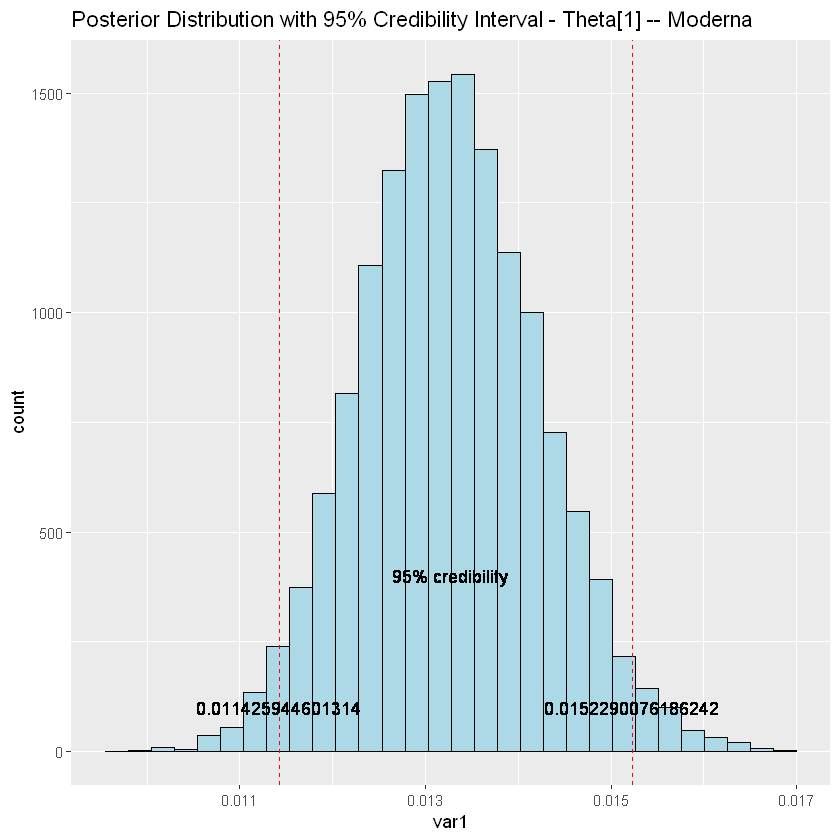

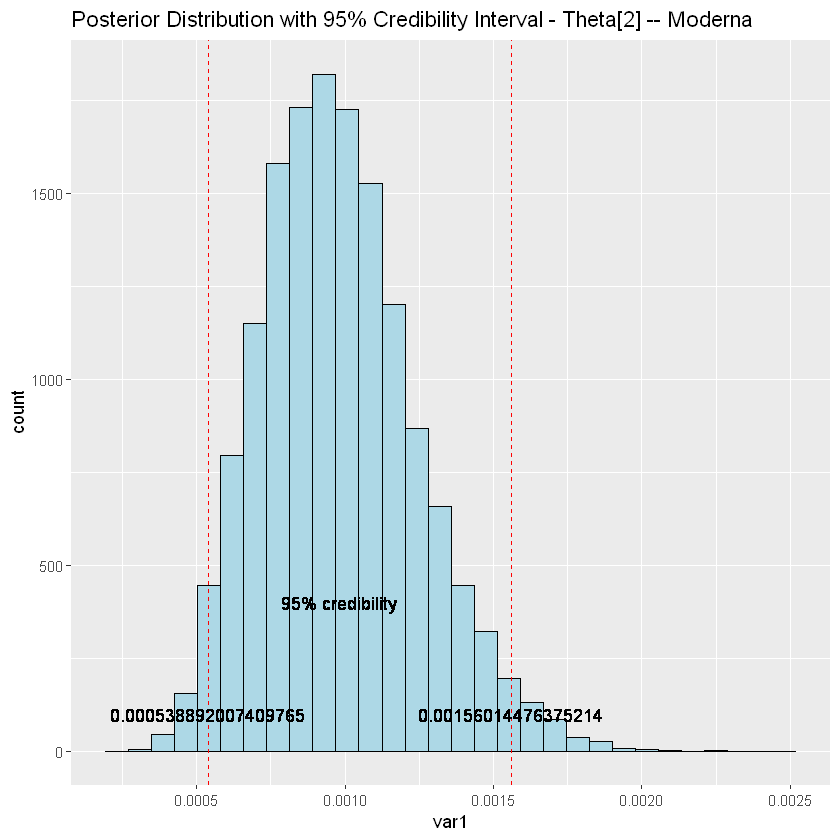

In [19]:
## Moderna
summary(posterior_moderna)

# calculate the 95% credibility interval
cred_interval_1 <- quantile(posterior_moderna[[1]][,1], probs = c(0.025, 0.975))
cred_interval_2 <- quantile(posterior_moderna[[1]][,2], probs = c(0.025, 0.975))

# store in dataframe
df_1 <- data.frame(theta = posterior_moderna[[1]][,1])
df_2 <- data.frame(theta = posterior_moderna[[1]][,2])

# plot posterior density with 95% credibility interval using ggplot2
# plot(posterior_moderna, trace=FALSE)
ggplot(df_1, aes(x = var1)) +
    #geom_density(fill = "lightblue", color = "black") +
    geom_histogram(fill = "lightblue", color = "black", bins=30) +
    geom_vline(xintercept = cred_interval_1, linetype = "dashed", color = "red") +
    geom_text(x = mean(df_1$var1), y = 400, angle = 0, label = "95% credibility") +
    geom_text(x = cred_interval_1[1], y = 100, angle = 0, label = paste(cred_interval_1[1])) +
    geom_text(x = cred_interval_1[2], y = 100, angle = 0, label = paste(cred_interval_1[2])) +
    labs(title = "Posterior Distribution with 95% Credibility Interval - Theta[1] -- Moderna")

ggplot(df_2, aes(x = var1)) +
    #geom_density(fill = "lightblue", color = "black") +
    geom_histogram(fill = "lightblue", color = "black", bins=30) +
    geom_vline(xintercept = cred_interval_2, linetype = "dashed", color = "red") +
    geom_text(x = mean(df_2$var1), y = 400, angle = 0, label = "95% credibility") +
    geom_text(x = cred_interval_2[1], y = 100, angle = 0, label = paste(cred_interval_2[1])) +
    geom_text(x = cred_interval_2[2], y = 100, angle = 0, label = paste(cred_interval_2[2])) +
    labs(title = "Posterior Distribution with 95% Credibility Interval - Theta[2] -- Moderna")


Iterations = 1:15000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 15000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

            Mean       SD  Naive SE Time-series SE
theta[1] 0.02953 0.002313 1.888e-05      1.888e-05
theta[2] 0.01250 0.001511 1.234e-05      1.234e-05

2. Quantiles for each variable:

             2.5%     25%     50%     75%   97.5%
theta[1] 0.025242 0.02794 0.02946 0.03106 0.03420
theta[2] 0.009727 0.01145 0.01243 0.01349 0.01565


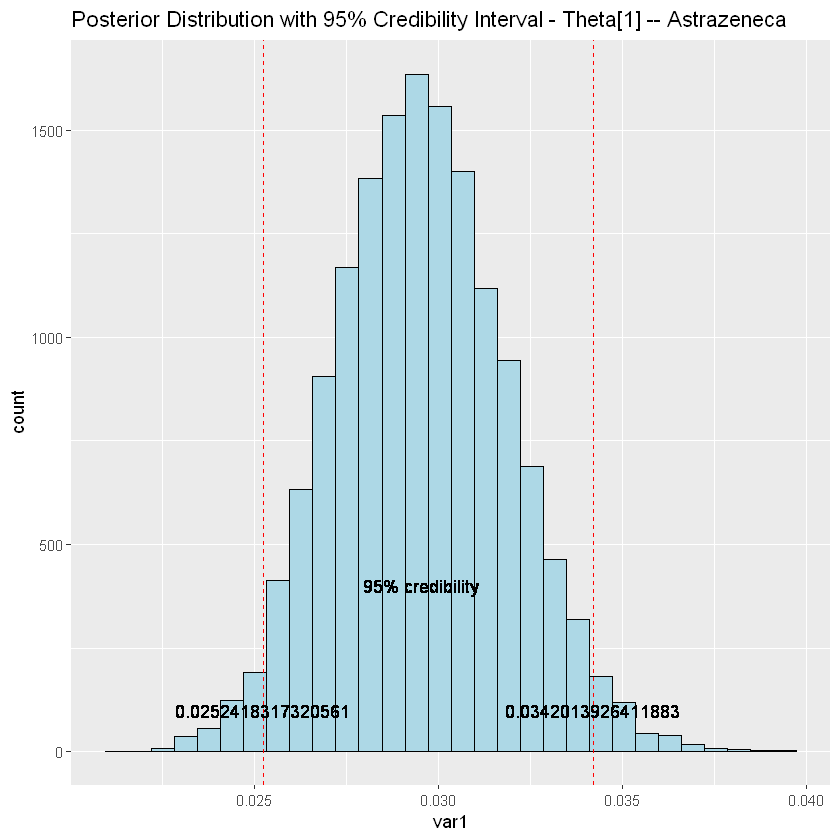

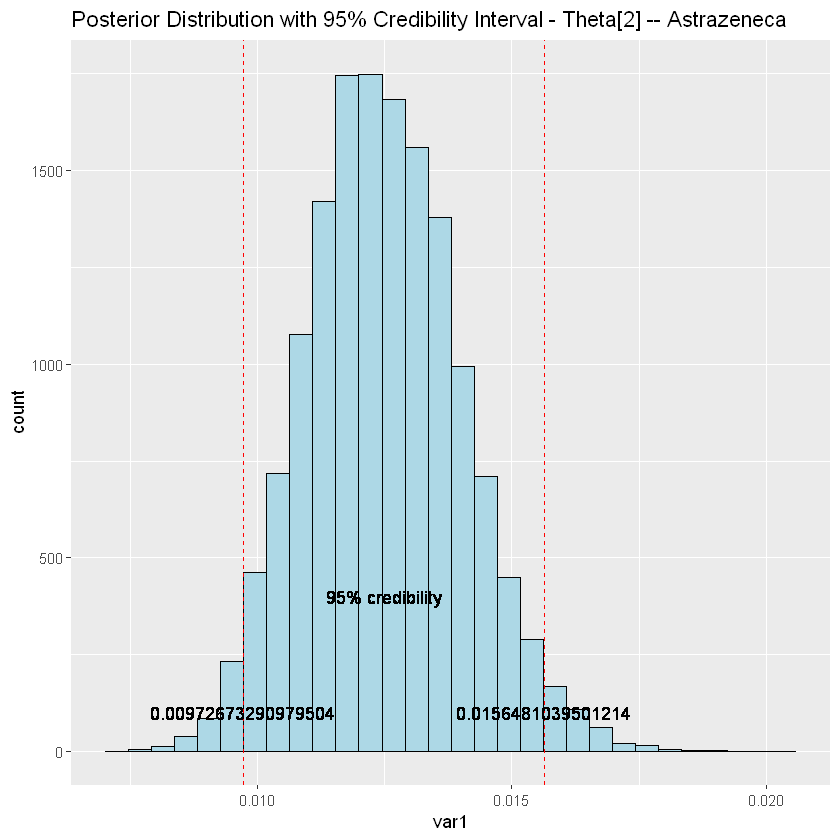

In [20]:
## Astrazeneca
summary(posterior_astrazeneca)

# calculate the 95% credibility interval
cred_interval_1 <- quantile(posterior_astrazeneca[[1]][,1], probs = c(0.025, 0.975))
cred_interval_2 <- quantile(posterior_astrazeneca[[1]][,2], probs = c(0.025, 0.975))

# store in dataframe
df_1 <- data.frame(theta = posterior_astrazeneca[[1]][,1])
df_2 <- data.frame(theta = posterior_astrazeneca[[1]][,2])

# plot posterior density with 95% credibility interval using ggplot2
# plot(posterior_moderna, trace=FALSE)
ggplot(df_1, aes(x = var1)) +
    #geom_density(fill = "lightblue", color = "black") +
    geom_histogram(fill = "lightblue", color = "black", bins=30) +
    geom_vline(xintercept = cred_interval_1, linetype = "dashed", color = "red") +
    geom_text(x = mean(df_1$var1), y = 400, angle = 0, label = "95% credibility") +
    geom_text(x = cred_interval_1[1], y = 100, angle = 0, label = paste(cred_interval_1[1])) +
    geom_text(x = cred_interval_1[2], y = 100, angle = 0, label = paste(cred_interval_1[2])) +
    labs(title = "Posterior Distribution with 95% Credibility Interval - Theta[1] -- Astrazeneca")

ggplot(df_2, aes(x = var1)) +
    #geom_density(fill = "lightblue", color = "black") +
    geom_histogram(fill = "lightblue", color = "black", bins=30) +
    geom_vline(xintercept = cred_interval_2, linetype = "dashed", color = "red") +
    geom_text(x = mean(df_2$var1), y = 400, angle = 0, label = "95% credibility") +
    geom_text(x = cred_interval_2[1], y = 100, angle = 0, label = paste(cred_interval_2[1])) +
    geom_text(x = cred_interval_2[2], y = 100, angle = 0, label = paste(cred_interval_2[2])) +
    labs(title = "Posterior Distribution with 95% Credibility Interval - Theta[2] -- Astrazeneca")


Iterations = 1:15000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 15000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

             Mean        SD  Naive SE Time-series SE
theta[1] 0.017736 0.0009415 7.687e-06      7.687e-06
theta[2] 0.006025 0.0005531 4.516e-06      4.459e-06

2. Quantiles for each variable:

             2.5%      25%      50%      75%    97.5%
theta[1] 0.015909 0.017096 0.017718 0.018368 0.019608
theta[2] 0.004988 0.005644 0.006012 0.006389 0.007154


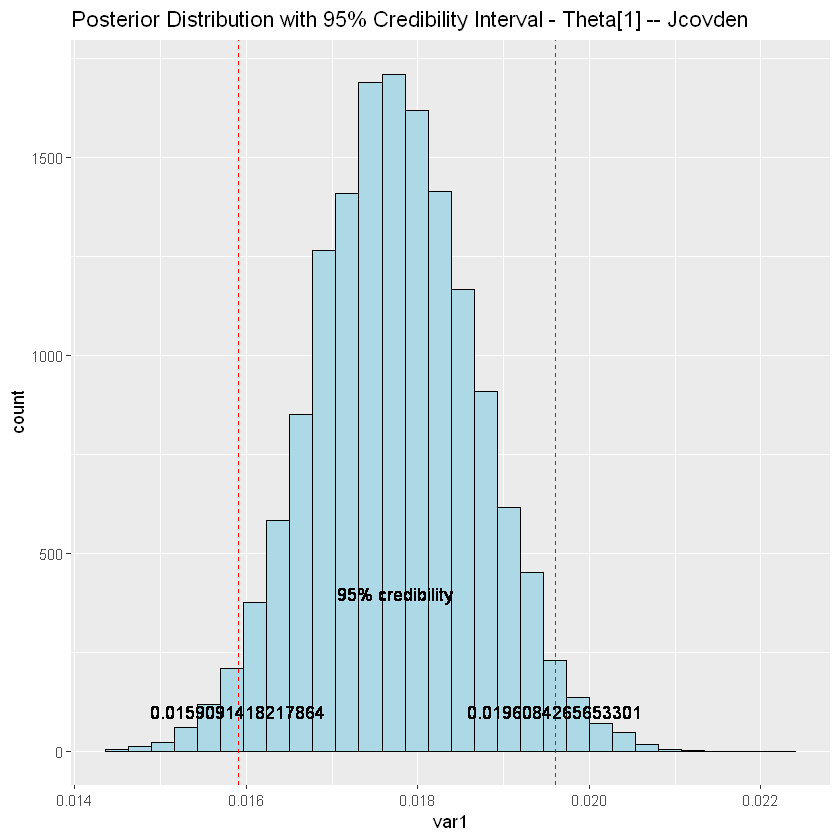

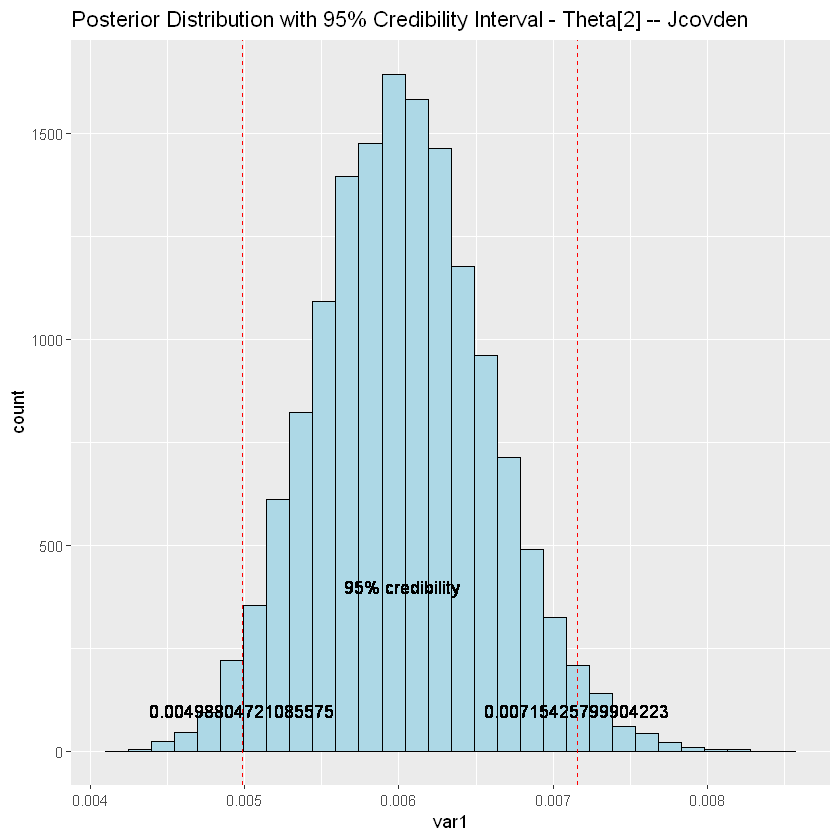

In [21]:
## jcovden
summary(posterior_jcovden)

# calculate the 95% credibility interval
cred_interval_1 <- quantile(posterior_jcovden[[1]][,1], probs = c(0.025, 0.975))
cred_interval_2 <- quantile(posterior_jcovden[[1]][,2], probs = c(0.025, 0.975))

# store in dataframe
df_1 <- data.frame(theta = posterior_jcovden[[1]][,1])
df_2 <- data.frame(theta = posterior_jcovden[[1]][,2])

# plot posterior density with 95% credibility interval using ggplot2
# plot(posterior_moderna, trace=FALSE)
ggplot(df_1, aes(x = var1)) +
    #geom_density(fill = "lightblue", color = "black") +
    geom_histogram(fill = "lightblue", color = "black", bins=30) +
    geom_vline(xintercept = cred_interval_1, linetype = "dashed", color = "red") +
    geom_text(x = mean(df_1$var1), y = 400, angle = 0, label = "95% credibility") +
    geom_text(x = cred_interval_1[1], y = 100, angle = 0, label = paste(cred_interval_1[1])) +
    geom_text(x = cred_interval_1[2], y = 100, angle = 0, label = paste(cred_interval_1[2])) +
    labs(title = "Posterior Distribution with 95% Credibility Interval - Theta[1] -- Jcovden")

ggplot(df_2, aes(x = var1)) +
    #geom_density(fill = "lightblue", color = "black") +
    geom_histogram(fill = "lightblue", color = "black", bins=30) +
    geom_vline(xintercept = cred_interval_2, linetype = "dashed", color = "red") +
    geom_text(x = mean(df_2$var1), y = 400, angle = 0, label = "95% credibility") +
    geom_text(x = cred_interval_2[1], y = 100, angle = 0, label = paste(cred_interval_2[1])) +
    geom_text(x = cred_interval_2[2], y = 100, angle = 0, label = paste(cred_interval_2[2])) +
    labs(title = "Posterior Distribution with 95% Credibility Interval - Theta[2] -- Jcovden")

### Exercise 3

- according to the official COVID-19 vaccination data, 70% of the world population has received at least one dose of a COVID-19 vaccine. A global vaccination dataset is available [5]

- the European Centre for Disease Prevention and Control published a downloadable file [6] containing information on COVID-19 vaccination in the EU/EEA.

In [22]:
# load files
vaccine_data = read.csv('owid-covid-data.csv',sep=',')
vaccine_data

iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,⋯,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AFG,Asia,Afghanistan,2020-01-03,NA,0,NA,NA,0,NA,⋯,NA,37.746,0.5,64.83,0.511,41128772,NA,NA,NA,NA
AFG,Asia,Afghanistan,2020-01-04,NA,0,NA,NA,0,NA,⋯,NA,37.746,0.5,64.83,0.511,41128772,NA,NA,NA,NA
AFG,Asia,Afghanistan,2020-01-05,NA,0,NA,NA,0,NA,⋯,NA,37.746,0.5,64.83,0.511,41128772,NA,NA,NA,NA
AFG,Asia,Afghanistan,2020-01-06,NA,0,NA,NA,0,NA,⋯,NA,37.746,0.5,64.83,0.511,41128772,NA,NA,NA,NA
AFG,Asia,Afghanistan,2020-01-07,NA,0,NA,NA,0,NA,⋯,NA,37.746,0.5,64.83,0.511,41128772,NA,NA,NA,NA
AFG,Asia,Afghanistan,2020-01-08,NA,0,0,NA,0,0,⋯,NA,37.746,0.5,64.83,0.511,41128772,NA,NA,NA,NA
AFG,Asia,Afghanistan,2020-01-09,NA,0,0,NA,0,0,⋯,NA,37.746,0.5,64.83,0.511,41128772,NA,NA,NA,NA
AFG,Asia,Afghanistan,2020-01-10,NA,0,0,NA,0,0,⋯,NA,37.746,0.5,64.83,0.511,41128772,NA,NA,NA,NA
AFG,Asia,Afghanistan,2020-01-11,NA,0,0,NA,0,0,⋯,NA,37.746,0.5,64.83,0.511,41128772,NA,NA,NA,NA


In [141]:
colnames(vaccine_data)


[1] "iso_code"                                  
 [2] "continent"                                 
 [3] "location"                                  
 [4] "date"                                      
 [5] "total_cases"                               
 [6] "new_cases"                                 
 [7] "new_cases_smoothed"                        
 [8] "total_deaths"                              
 [9] "new_deaths"                                
[10] "new_deaths_smoothed"                       
[11] "total_cases_per_million"                   
[12] "new_cases_per_million"                     
[13] "new_cases_smoothed_per_million"            
[14] "total_deaths_per_million"                  
[15] "new_deaths_per_million"                    
[16] "new_deaths_smoothed_per_million"           
[17] "reproduction_rate"                         
[18] "icu_patients"                              
[19] "icu_patients_per_million"                  
[20] "hosp_patients"                             
[21] "hosp_patients_per_million"                 
[22] "weekly_icu_admissions"                     
[23] "weekly_icu_admissions_per_million"         
[24] "weekly_hosp_admissions"                    
[25] "weekly_hosp_admissions_per_million"        
[26] "total_tests"                               
[27] "new_tests"                                 
[28] "total_tests_per_thousand"                  
[29] "new_tests_per_thousand"                    
[30] "new_tests_smoothed"                        
[31] "new_tests_smoothed_per_thousand"           
[32] "positive_rate"                             
[33] "tests_per_case"                            
[34] "tests_units"                               
[35] "total_vaccinations"                        
[36] "people_vaccinated"                         
[37] "people_fully_vaccinated"                   
[38] "total_boosters"                            
[39] "new_vaccinations"                          
[40] "new_vaccinations_smoothed"                 
[41] "total_vaccinations_per_hundred"            
[42] "people_vaccinated_per_hundred"             
[43] "people_fully_vaccinated_per_hundred"       
[44] "total_boosters_per_hundred"                
[45] "new_vaccinations_smoothed_per_million"     
[46] "new_people_vaccinated_smoothed"            
[47] "new_people_vaccinated_smoothed_per_hundred"
[48] "stringency_index"                          
[49] "population_density"                        
[50] "median_age"                                
[51] "aged_65_older"                             
[52] "aged_70_older"                             
[53] "gdp_per_capita"                            
[54] "extreme_poverty"                           
[55] "cardiovasc_death_rate"                     
[56] "diabetes_prevalence"                       
[57] "female_smokers"                            
[58] "male_smokers"                              
[59] "handwashing_facilities"                    
[60] "hospital_beds_per_thousand"                
[61] "life_expectancy"                           
[62] "human_development_index"                   
[63] "population"                                
[64] "excess_mortality_cumulative_absolute"      
[65] "excess_mortality_cumulative"               
[66] "excess_mortality"                          
[67] "excess_mortality_cumulative_per_million"

- analyze the data and produce the following plots:
    - number of vaccinated people (cumulative, daily and week average)
    - number of confirmed deaths by COVID-19, both cumulative and weekly average

In [33]:
# filter the data for the vaccinated
filtered_data <- vaccine_data %>%
                    select(iso_code, continent,location, date, people_vaccinated, people_fully_vaccinated, total_vaccinations, new_vaccinations,total_deaths,new_deaths) %>%
                    filter(location == 'World') %>%
                    mutate(date = as.Date(date))

In [34]:
# not nan values
colSums(!is.na(filtered_data))

iso_code               continent                location 
                   1247                    1247                    1247 
                   date       people_vaccinated people_fully_vaccinated 
                   1247                     913                     902 
     total_vaccinations        new_vaccinations            total_deaths 
                    913                     907                    1236 
             new_deaths 
                   1245

In [35]:
# nan values
colSums(is.na(filtered_data))

iso_code               continent                location 
                      0                       0                       0 
                   date       people_vaccinated people_fully_vaccinated 
                      0                     334                     345 
     total_vaccinations        new_vaccinations            total_deaths 
                    334                     340                      11 
             new_deaths 
                      2

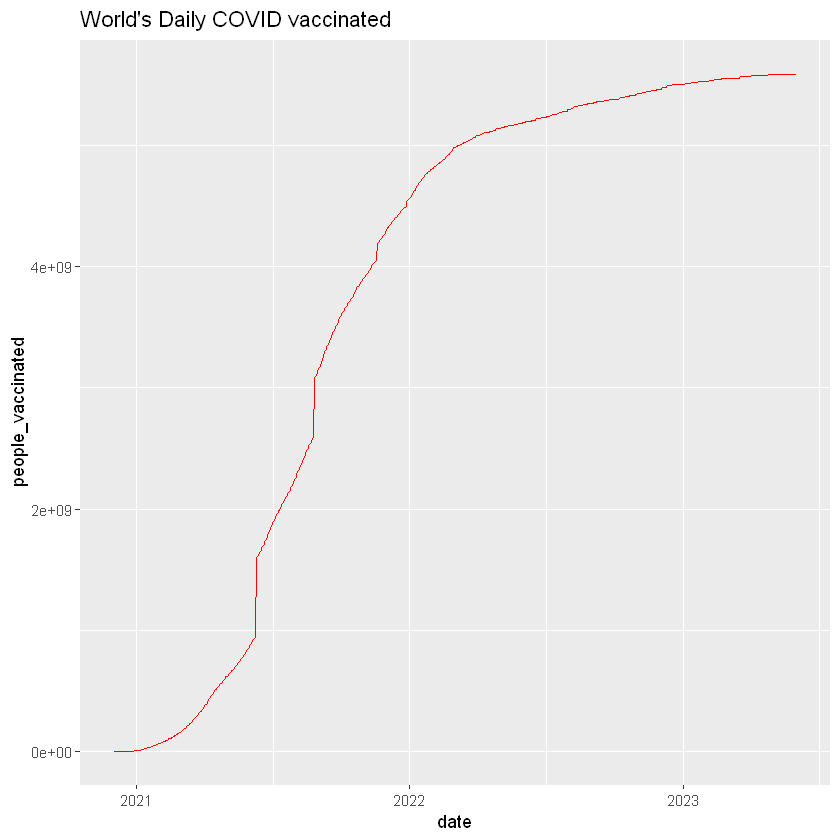

In [42]:
# daily vaccinated people
daily_data <- filtered_data %>% 
                  filter(!is.na(people_vaccinated)) %>%
                  ggplot(aes(x = date,y = people_vaccinated))+
                  geom_line(color = 'red')+
                  ggtitle('World\'s Daily COVID vaccinated')

daily_data

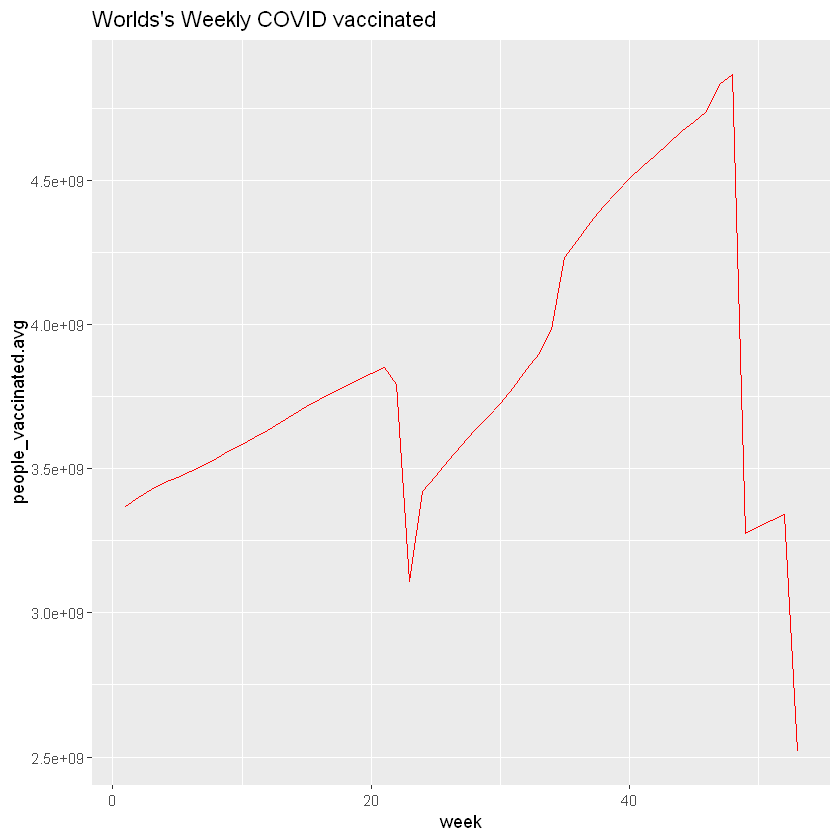

In [50]:
# Weekly filter for vaccinated
weekly_data <- filtered_data %>%
                    filter(!is.na(people_vaccinated)) %>%
                    group_by(week = week(date)) %>%
                    mutate(people_vaccinated.avg = mean(people_vaccinated)) %>%
                    
                    
                    ggplot(aes(x = week,y = people_vaccinated.avg))+
                    geom_line(color = 'red')+
                    ggtitle('Worlds\'s Weekly COVID vaccinated')

weekly_data

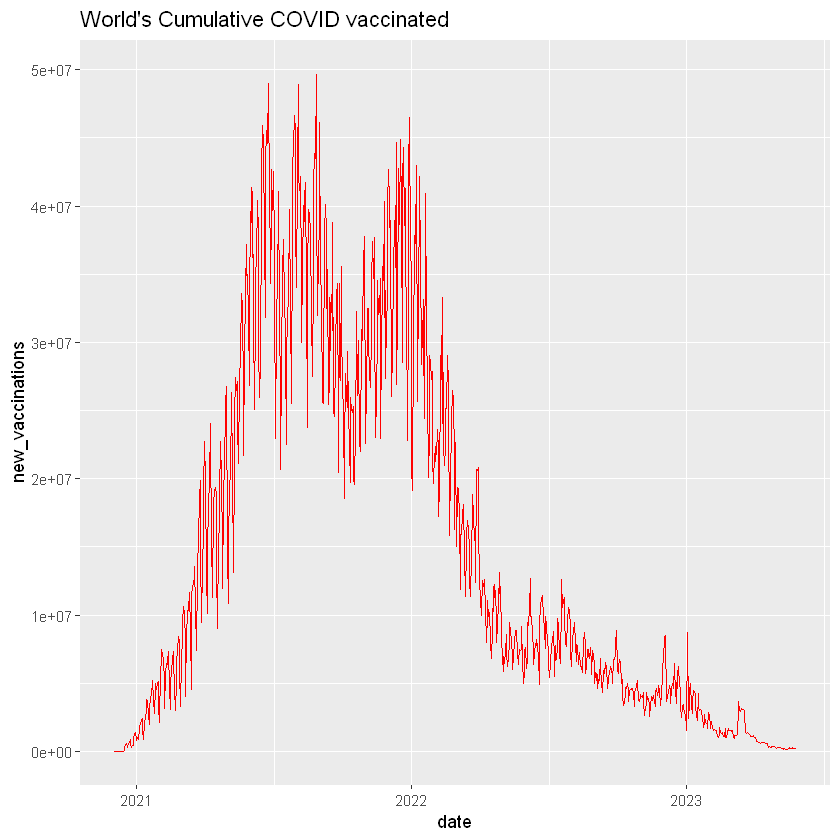

In [47]:
# cumulative vaccinated people
cumulative_data <- filtered_data %>% 
                  filter(!is.na(new_vaccinations)) %>%
                  ggplot(aes(x = date,y = new_vaccinations))+
                  geom_line(color = 'red')+
                  ggtitle('World\'s Cumulative COVID vaccinated')
cumulative_data

##### Deaths

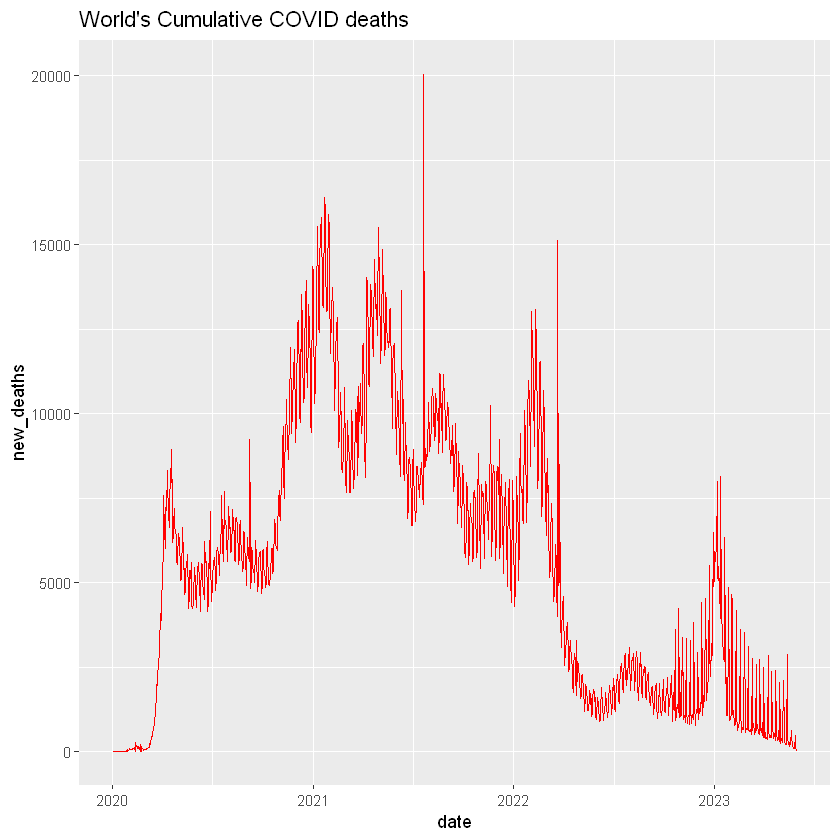

In [46]:
# cumulative new_deaths people
cumulative_data_deaths <- filtered_data %>% 
                          filter(!is.na(new_deaths)) %>%
                          ggplot(aes(x = date,y = new_deaths))+
                          geom_line(color = 'red')+
                          ggtitle('World\'s Cumulative COVID deaths')
cumulative_data_deaths

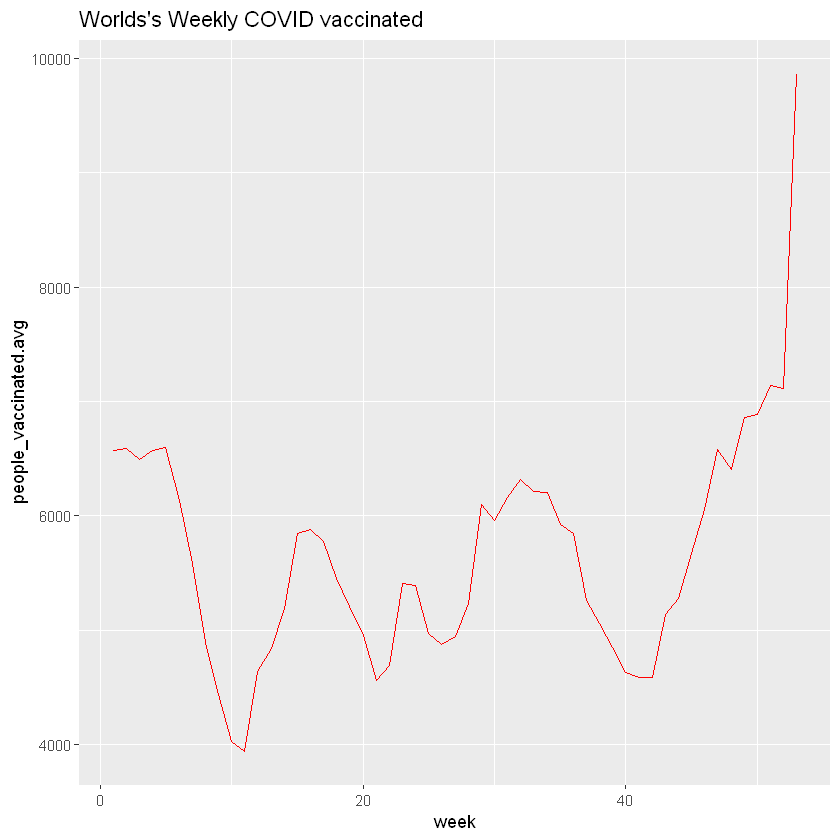

In [49]:
# Weekly filter for vaccinated
weekly_data_deaths <- filtered_data %>%
                    filter(!is.na(new_deaths)) %>%
                    group_by(week = week(date)) %>%
                    mutate(people_vaccinated.avg = mean(new_deaths)) %>%
                    
                    
                    ggplot(aes(x = week,y = people_vaccinated.avg))+
                    geom_line(color = 'red')+
                    ggtitle('Worlds\'s Weekly COVID vaccinated')

weekly_data_deaths